<a href="https://colab.research.google.com/github/bawfeh/SEM1D/blob/main/notebookbe36c1e39a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'mnist-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F102285%2F242592%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240305%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240305T131925Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D53e71775f34095bf5527de2ad6da99d1a0845dfca2643a94411a8a8bd6333abe56bdf091aa7f007710711a311bf66bd291482c7497296e9bbf950cc99c1841209dd0b6e66bb578ba197ea9fe01faaa2d09e53741d98450e4639daef7ed8da86931b8141cef65692a0b606ff9c7986a91c6e167e1eb9287035d4e044ba4027150e48c04a97d31133f58a9e8990c89180ec0aa0c4abeea32fb98ce0a044fe8b0c0ff520f9963cce6dd54675aacf3d2625a02cde133e96965036a8c5a72f8b9f929c046a660303902fc91419d732696212e82da80001a6e6e2981497ddbfbcb7be5dacf17a5d2e3b5b8cede5ac78cd1f65874c9da9cc458cf4468b5cd19b2f002ac,customclasses:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4464838%2F7758897%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240305%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240305T131925Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D584d40621d834a3f2f31857254487612f91617b8483628f161222ba9ab53ed0abb005bb16abb9db63aad945e89bedbbf270abcd528c984d38a60f8e4e1a13626df51f5fa83c6241b8cbaa1d22a3b71319143cf5e2ffe606e320f9b5de20b9e834e7b1b06e692e3c33554baee4a70b1ad7ed97f30b3d60d2ac2c3e79fb907bc8c8714867d6ffa91ddc8ced06a19f798f90681dac5752a928b967077be811504d2a85c26422e2fa98b02eabf9b96463c95faf31a6e56ed7031dccf2f688f8f899ebe5a510dd8d64f6aa60c3ec8b7ff23222489101bf0dfe97281f327622466334ca60c42ea7b27305e549c963d9c937185b2a149d6f868e82a104c3e765e61ea10'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 23112702 bytes downloaded
Downloaded and uncompressed: mnist-dataset
[==================================================] 6744 bytes downloaded
Downloaded and uncompressed: customclasses
Data source import complete.


In [2]:
import keras
from keras import layers
import re, os, time

custom_dir = os.path.join('/kaggle/input', 'customclasses')
if custom_dir not in os.sys.path:
    os.sys.path.insert(0, custom_dir)

RND_STATE = 247
keras.utils.set_random_seed(RND_STATE)

# Import all custom variables and modules
from preprocessing import *
from ae import *

## Autoencoders
Following tutorial [Blog by F.Chollet](https://blog.keras.io/building-autoencoders-in-keras.html)

### 1. Dense Autoencoders

In [3]:
# Load MNIST digit dataset
#
input_path = '../input/mnist-dataset'
digits = MNIST_digits(input_path)

(x_train_, _), (x_test_, _) = digits.load_data()
img_shape = x_train_.shape[1:]

x_train = digits.normalize(x_train_, add_panel=False)
x_test = digits.normalize(x_test_, add_panel=False)
x_train = x_train.reshape((len(x_train), np.prod(img_shape)))
x_test = x_test.reshape((len(x_test), np.prod(img_shape)))


print("Dimension of training dataset: {:>15}".format(str(x_train.shape)))
print("Dimension of test dataset: {:>15}".format(str(x_test.shape)))

Dimension of training dataset:    (60000, 784)
Dimension of test dataset:    (10000, 784)


In [4]:
# Model configurations
conf = model_config()
conf.config('compile') #, metrics=[keras.metrics.F1Score(name='f1_score')])

es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    #monitor="f1_score",
    patience=5,
    verbose=1,
    restore_best_weights=True
)

conf.config(
    epochs=100,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[es_callback],
    verbose=0
)

In [5]:
model = AE_dense(latent_dim=32, input_shape=x_train.shape[1:], depth=3)
# model.encoder.summary()
# model.decoder.summary()
model.autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 784)]             0         
                                                                 
 encode_2 (Dense)            (None, 128)               100480    
                                                                 
 encode_1 (Dense)            (None, 64)                8256      
                                                                 
 encode_0 (Dense)            (None, 32)                2080      
                                                                 
 decode_0 (Dense)            (None, 32)                1056      
                                                                 
 decode_1 (Dense)            (None, 64)                2112      
                                                                 
 decode_2 (Dense)            (None, 128)               

In [6]:
model.autoencoder.compile(**conf.compile_args)


conf.config(x=x_train, y=x_train, validation_data=(x_test, x_test))

start = time.time()

history = model.autoencoder.fit(**conf.training_args)

print('training elapsed time: ___{:5.2f} minutes___'.format((time.time()-start) / 60))

training elapsed time: ___ 1.84 minutes___


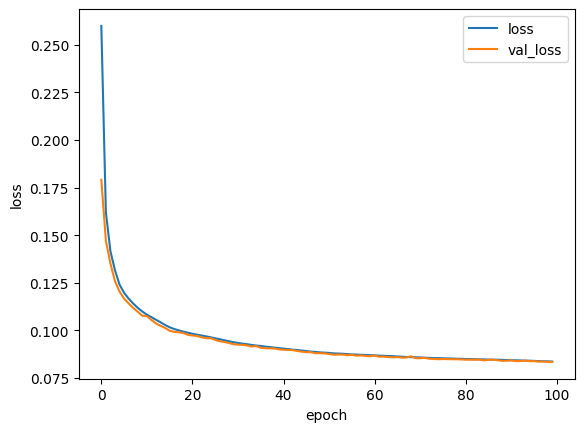

In [7]:
show_convergence(history, metrics=['loss','val_loss'])

In [8]:
decoded_imgs = model.predict(x_test)

model.evaluate(x_test,decoded_imgs, threshold=0.8, report=True)

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.95      0.97   7385117
           1       0.54      0.91      0.68    454883

    accuracy                           0.95   7840000
   macro avg       0.77      0.93      0.83   7840000
weighted avg       0.97      0.95      0.96   7840000



(0.6724595606191499, 0.68, 0.68)

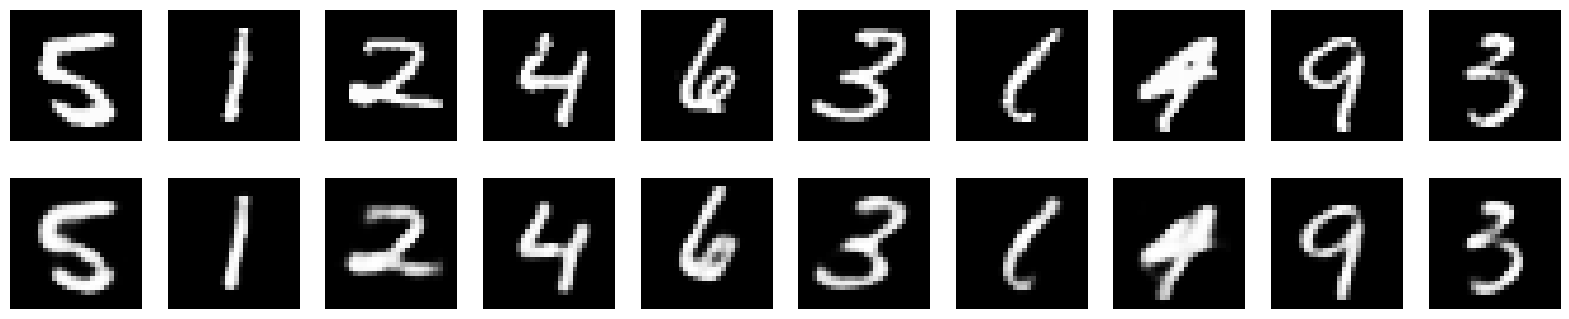

In [9]:
display_sample_images(x_test, decoded_imgs, img_shape)


### 2. Convolutional Autoencoders

In [10]:
x_train = digits.normalize(x_train_)
x_test = digits.normalize(x_test_)


In [11]:
model2 = AE_convolutional(input_shape=x_train.shape[1:], panel_size=[16, 8, 8])
model2.autoencoder.summary()


shape of input image:  (28, 28)
shape of output image:  (28, 28)
Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 Conv2D_2 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 encode_2 (MaxPooling2D)     (None, 14, 14, 16)        0         
                                                                 
 Conv2D_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 encode_1 (MaxPooling2D)     (None, 7, 7, 8)           0         
                                                                 
 Conv2DT_0 (Conv2D)          (None, 7, 7, 8)           584       
                                                        

In [12]:
model2.autoencoder.compile(**conf.compile_args)

start = time.time()

conf.config( x=x_train, y=x_train, validation_data=(x_test, x_test) )

history = model2.autoencoder.fit( **conf.training_args )

print('train time: {:5.2f}___minutes___'.format((time.time()-start) / 60))

train time:  2.29___minutes___


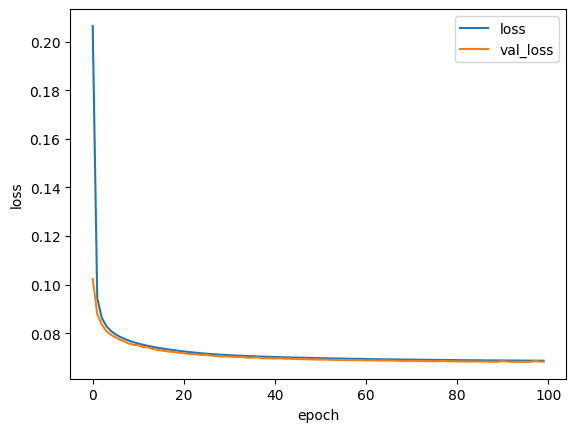

In [13]:
show_convergence(history, metrics=['loss','val_loss'])

In [14]:
decoded_imgs = model2.predict(x_test)

model2.evaluate(x_test,decoded_imgs, threshold=0.8, report=True)

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       1.00      0.95      0.97   7385117
           1       0.53      0.99      0.69    454883

    accuracy                           0.95   7840000
   macro avg       0.76      0.97      0.83   7840000
weighted avg       0.97      0.95      0.96   7840000



(0.718542765885781, 0.69, 0.69)

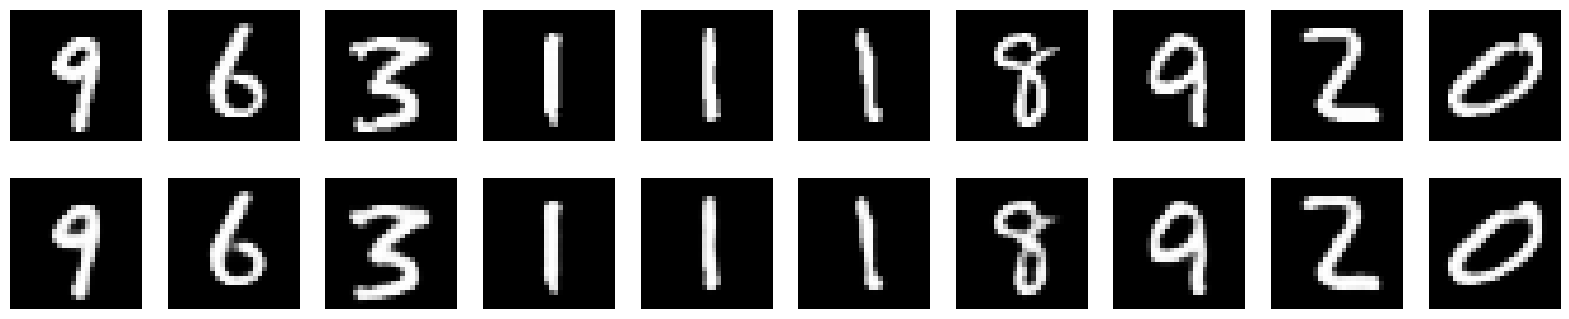

In [15]:
display_sample_images(x_test, decoded_imgs, img_shape)

#### Noise added

In [16]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [17]:
decoded_imgs = model2.predict(x_test_noisy)

model2.evaluate(x_test,decoded_imgs, threshold=0.8, report=True)

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97   7385117
           1       0.48      0.65      0.55    454883

    accuracy                           0.94   7840000
   macro avg       0.73      0.80      0.76   7840000
weighted avg       0.95      0.94      0.94   7840000



(0.5156444712572351, 0.55, 0.55)

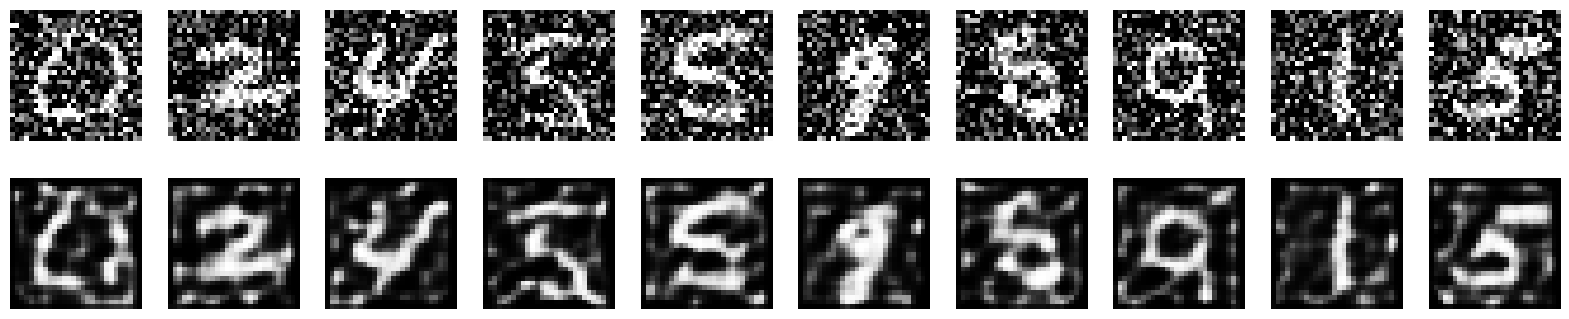

In [18]:
display_sample_images(x_test_noisy, decoded_imgs, img_shape)

#### Add more kernels to train on noisy data

In [19]:
model3 = AE_convolutional(input_shape=x_train.shape[1:], panel_size=[32,32])
model3.autoencoder.summary()

shape of input image:  (28, 28)
shape of output image:  (28, 28)
Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 Conv2D_1 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 encode_1 (MaxPooling2D)     (None, 14, 14, 32)        0         
                                                                 
 Conv2D_0 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 encode_0 (MaxPooling2D)     (None, 7, 7, 32)          0         
                                                                 
 Conv2DT_0 (Conv2D)          (None, 7, 7, 32)          9248      
                                                        

In [20]:
model3.autoencoder.compile(**conf.compile_args)

conf.config(
    x=x_train_noisy, y=x_train,
    validation_data=(x_test_noisy, x_test)
)

start = time.time()

history = model3.autoencoder.fit( **conf.training_args )

print('train time: {:5.2f}___minutes___'.format((time.time()-start) / 60))
model3.training_args['epochs']

Restoring model weights from the end of the best epoch: 72.
Epoch 77: early stopping
train time:  2.80___minutes___


1

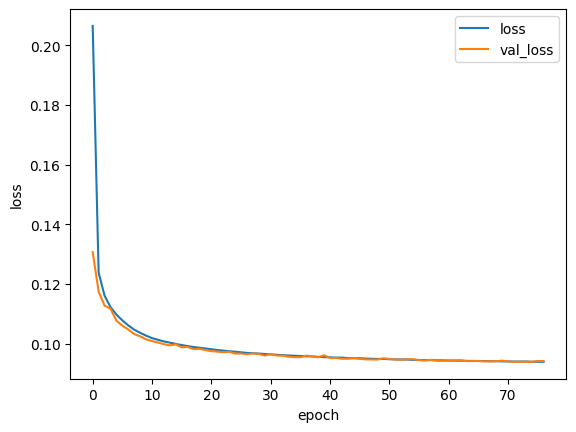

In [21]:
show_convergence(history, metrics=['loss','val_loss'])

In [22]:
decoded_imgs = model3.predict(x_test_noisy)

model3.evaluate(x_test,decoded_imgs, threshold=0.8, report=True)

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.95      0.97   7385117
           1       0.54      0.88      0.67    454883

    accuracy                           0.95   7840000
   macro avg       0.77      0.92      0.82   7840000
weighted avg       0.97      0.95      0.95   7840000



(0.6551977048709142, 0.67, 0.67)

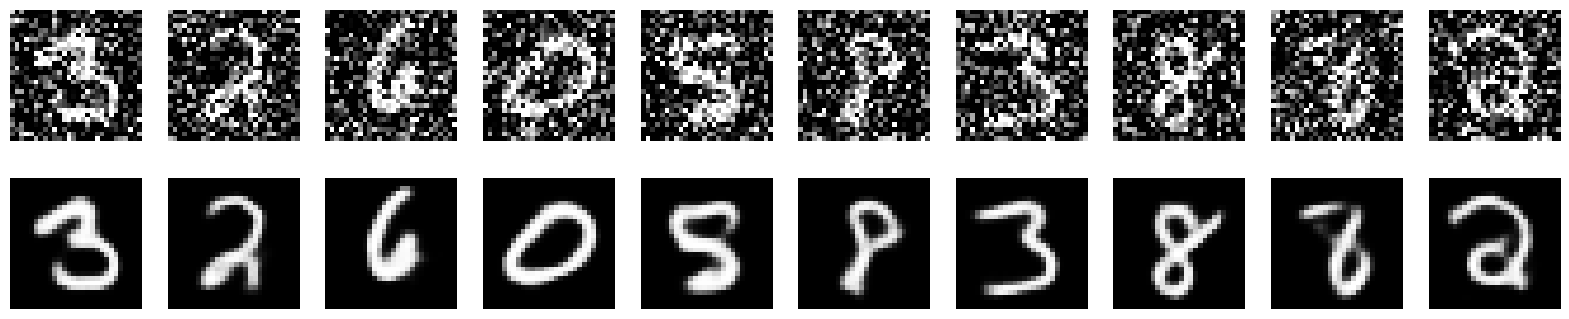

In [23]:
display_sample_images(x_test_noisy, decoded_imgs, img_shape)